**Trabalho Computacional 1**

**EEL7416 Introdução a Codificação**

**Códigos Corretores de Erros**

**ALUNO: ANDRÉ LUCAS SCHLICHTING 15150162**

**Introdução**

Este trabalho tem como objetivo demonstrar através de simulação computacional a probabilidade de erro de palavra-código para diferentes codificações em um sistema de transmissão binário simétrico.

As simulações foram feitas com o uso das bibliotecas matemáticas do python seguindo as instruções dadas.


**Estrutura**

Os blocos de código, quando necessárias quaisquer explicações em relação ao trabalho ou código, estão comentados com blocos de texto. Outros blocos de código possuem comentários dentro do próprio bloco.

In [1]:
from collections import defaultdict #Biblioteca de dicionários para manipulação de dados
import matplotlib.pyplot as plt #Biblioteca de plot
from functools import reduce #Biblioteca de operações múltiplas
import operator as op #Biblioteca de operações
import numpy as np #Biblioteca para uso de matrizes e vetores

import math #Biblioteca de funções matemáticas

Neste trabalho são analisados 3 códigos de bloco com taxas $R=k/7$, em que $k=$1,4 e 7. São os blocos de repetição, Hamming e bloco não codificado, respectivamente.

A probabilidade de erro teórica para o **código de repetição** é dada pela expressão:

$$
P_{erro} = 1-[(1-p)^7 +7p(1-p)^6+\binom{7}{2}p^2(1-p)^5+\binom{7}{3}p^3(1-p)^4]
$$

Para o **código hamming** a probabilidade de erro é dada por:

$$
P_{erro} = 1-[(1-p)^7 +7p(1-p)^6]
$$

Sendo a probabilidade de codificar corretamente um bit enviado em um espaço dada pela expressão

$$
Pr = (1-p)^n +\binom{n}{1}p(1-p)^{n-1}+...+\binom{n}{\frac{n-1}{2}}p^{\frac{n-1}{2}}(1-p)^\frac{n+1}{2}
$$

$$
Pr = \sum_{e=0}^{\frac{n-1}{2}}\binom{n}{e}p^e(1-p)^{n-e}
$$

A expressão para a probabilidade de erro do código cujo $k=7$ a exemplo das expressões acima para $k=1$ e $k=4$ e seguindo a expressão geral onde a probabilidade de erro é $P_{erro} = 1-Pr$ será:

$$
P_{erro} = 1-[(1-p)^7]
$$

In [2]:
def comb(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

#Perro para k=1
def repErrorProb(p):
    perr = ((1-p)**7) + (7*p*(1-p)**6) + (comb(7, 2)*(p**2)
                                          * ((1-p)**5)) + (comb(7, 3)*(p**3)*((1-p)**4))
    err = 1 - perr
    return err

#Perro para k=4
def hamErrorProb(p):
    perr = ((1-p)**7) + (7*p*((1-p)**6))
    err = 1 - perr
    return err

#Perro para k=7
def unoErrorProb(p):
    perr = ((1-p)**7)
    err = 1 - perr
    return err


def get_color_k(k):
    if k == 1:
        return 'r'
    elif k == 4:
        return 'g'
    else:
        return 'b'

No bloco abaixo temos as funções utilizadas para gerar mensagens aleatórias, codificá-las e adicionar ruído.

Uma mensagem aleatória binária pode ser gerada através do arredondamento dos valores gerados entre 0 e 1. Valores entre 0 e 0.5 são arredondados para 0 e valores maiores que 0.5 são arredondados para 1.

Para adicionar o ruído pode-se subtrair 0.5 do valor gerado e adicionar o erro de valor p. Dessa forma o arredndamento ficará tendenciado ao intervalo onde o valor estiver quando p for somado. Isso acontece porque  o canal é binário com probabilidade de 1 ser p e 0 ser 1-p.

In [3]:
#Cria uma mensagem aleatória de l bits
def create_message(l):
    return np.round(np.random.rand(1, l)).astype(int)[0]

#Codifica a mensagem m com a matriz geradora G
def encode(m, G):
    if len(G.shape) > 1:
        return np.dot(G, m) % 2
    else:
        return G*m

#Adicional a mensagem m um erro de probabilide p
def noisy(m, p):
    e = np.round(np.random.rand(1, 7)-0.5+p)
    return np.logical_xor(m, e).astype(int)[0]


def make_message(k, p, G):
    m = create_message(k)
    menc = encode(m, G)
    mnoisy = noisy(menc, p)
    return menc, mnoisy

Neste trabalho, duas formas de decodificar a mensagem recebida para o código hamming foram implementadas. Uma faz o uso da matriz verificadora e outra forma faz o uso da decodificação exaustiva e distância hamming, comparando a palavra recebida com todas as palavras código possíveis.

# Código Hamming

Uma mensagem aleatória $u$ de 4 bits é criada e codificada com a matriz G abaixo:

$$G = \begin{bmatrix}
1 & 1 & 0 & 1\\ 
1 & 0 & 1 & 1\\ 
1 & 0 & 0 & 0 \\ 
0 & 1 & 1 & 1\\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & 1 & 0\\ 
0 & 0 & 0 & 1
\end{bmatrix}
$$

a mensagem aleatória é codificada segundo a expressão

$$v = Gu$$

A palavr código recebida é então decodificada usando a matriz

$$H =\begin{bmatrix}
1 &0  &1  & 0 &1  &0  &1 \\ 
 0&1  &1  &0  &0  &1  &1 \\ 
0 & 0 &0  &1  &1  &1  &1 
\end{bmatrix}
$$

da seguinte maneira

$$\hat{v} = Hr$$

onde $r$ é a palavra código recebida adicionada de ruído $e$

$$r = v+e$$

Caso $\hat{v}$ seja nulo, a palavra código decodificada é a própria mensagem recebida $r$. Caso contrário, altera-se na mensagem recebida o bit correspondente a posição na matriz H em que se encontra $\hat{v}$.

## Decodifição exaustiva

Todas as $2^4$  palavras chave podem ser geradas através da matriz $G$. A decodificação através da distância de hamming se faz comparando a mensagem recebida $r$ com todas as palavras chave possíveis e escolhendo a de menor distância.


In [4]:
def hamming(k, p, L, G, H, Kwords):
    def decode_H(m, H):
        decoded_message = np.dot(H, m) % 2
        if np.sum(decoded_message) == 0:
            v_hyp = noisy_message
        else:
            ei = np.where((np.transpose(H) == tuple(
                decoded_message)).all(axis=1))[0][0]
            v_hyp = noisy_message
            v_hyp[ei] = int(not(v_hyp[ei]))

        return v_hyp
        # return np.dot(H, m) % 2

    def decode_exaustivo(m, Kwords):
        min_d = k+1
        for kword in Kwords:
            d = np.count_nonzero(kword - m)
            if d < min_d:
                min_d = d
                v_hyp = kword

        return v_hyp

    err_H = 0
    err_exaustivo = 0
    for i in range(L):
        encoded_message, noisy_message = make_message(k, p, G)
        v_hyp_H = decode_H(noisy_message, H)
        v_hyp_exaustivo = decode_exaustivo(noisy_message, Kwords)

        if not np.array_equal(encoded_message, v_hyp_H):
            err_H += 1
        if not np.array_equal(encoded_message, v_hyp_exaustivo):
            err_exaustivo += 1

    return (err_H/L, err_exaustivo/L)

# Código de repetição

Para o código de repetição decide-se que a palavra recebida é $\hat{v} = (1111111)$ se a maioria dos bits na palavra recebida for 1, caso contrário opta-se por $\hat{v} = (0000000)$.

In [5]:
def repetition(k, p, L, G):
    err = 0
    for i in range(L):
        encoded_message, noisy_message = make_message(k, p, G)
        n_nonzeros = np.count_nonzero(noisy_message)
        n_zeros = len(noisy_message)-n_nonzeros
        if n_nonzeros > n_zeros:
            v_hyp = np.ones(7).astype(int)
        else:
            v_hyp = np.zeros(7).astype(int)

        if not np.array_equal(encoded_message, v_hyp):
            err += 1

    Pe = err/L
    return Pe

# Código k=7/7

Neste código a palavra decodificada é a própria palavra recebida.

In [6]:
def func(k, p, L, G):
    err = 0
    for i in range(L):
        encoded_message, noisy_message = make_message(k, p, G)
        v_hyp = noisy_message
        if not np.array_equal(encoded_message, v_hyp):
            err += 1
    Pe = err/L
    return Pe

# Simulação

Na simulação foram executadas 500 vezes o código para os códigos descritos acima e algumas probabilidades de erro chamadas de p_ no código. A matriz geradora G para cada códig está mostrada abaixo.

Para a decodificação do código hamming, uma lista de dados contém todas as palavras código possíveis geradas com a matriz geradora G. A matriz H para decodificação também está mostrada no bloco abaixo.

No laço principal, para cada valor de p_ são executadas L vezes cada um dos 3 códigos em análise. Em cada código uma mensagem $u$ é gerada, essa mensagem $u$ é codificada através de $v=uG$. Essa mensagem codificada é então adicionada de ruído e torna-se a palavra recebida $r=v+e$. A mensagem recebida é então decodificada utilizando-se das técnicas de cada código respectivamente, como descrito nos itens anteriores. Para o código hamming, duas decodificações são feitas, a exaustiva e utilizando a matriz verificadora $H$. Então compara-se a palavra decodificada com a palara código codificada a priori e decide-se se há um erro ou acerto. A contabilização dos erros sobre o total de execuções nos dá a probabilidade de erro do código.

In [7]:
L = 500
k_ = [1, 4, 7]
p_ = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

G_ = {
    1/7: np.array([1, 1, 1, 1, 1, 1, 1]),
    4/7: np.array([[1, 1, 0, 1],
                   [1, 0, 1, 1],
                   [1, 0, 0, 0],
                   [0, 1, 1, 1],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]]),
    7/7: np.array([1])
}

k = 4
Kwords_ = []
for i in range(2**k):
    b = '{0:04b}'.format(i)
    x = np.array([int(x) for x in b])
    Kwords_.append(np.dot(G_[k/7], x) % 2)


H_ = np.array([[1, 0, 1, 0, 1, 0, 1],
               [0, 1, 1, 0, 0, 1, 1],
               [0, 0, 0, 1, 1, 1, 1]])

res = defaultdict(lambda: defaultdict(int))
res2 = {}
for p in p_:
    k = 4
    Pe_H, Pe_exaustivo = hamming(k, p, L, G_[k/7], H_, Kwords_)
    res[k][p] = Pe_H
    res2[p] = Pe_exaustivo
    #print("Pe k={k} p={p} : {Pe}".format(**locals()))

    k = 1
    Pe = repetition(k, p, L, G_[k/7])
    res[k][p] = Pe
    #print("Pe k={k} p={p} : {Pe}".format(**locals()))

    k = 7
    Pe = func(k, p, L, G_[k/7])
    res[k][p] = Pe
    #print("Pe k={k} p={p} : {Pe}".format(**locals()))

# Resultados

A figura gerada pelo bloco de código abaixo mostra as linhas teóricas e os valores simulados para cada código.
Observa-se que para menores valores de k a probabilidade de erro é menor. Isso ocorre devido a quantidade de informação redundante enviada para se enviar apenas 1 bit através do canal simétrico.

Para k=1, que é o código de repetição, repete-se várias vezes o bit a ser enviado, dessa forma é difícil que o erro afete a maioria dos bits fazendo com que a mensagem interpretada na recepção se inverta.

Para k=4, menos redundância é adicionada, além de uma forma de conseguir verificar e corrigir ao menos 1 bit de mensagem.

Para k=7, a própria mensagem é enviada sem nenhum tipo de segurança ao redor para garantir a transmissão e recepção, tornando a quantidade de erros muito maior quando comparada aos outros códigos.



In [8]:
Pe_hamming = [hamErrorProb(p) for p in p_]
Pe_rep = [repErrorProb(p) for p in p_]
Pe_uno = [unoErrorProb(p) for p in p_]

#plt.figure()
#plt.grid()
#plt.plot(p_, Pe_rep, get_color_k(1)+'--')
#plt.plot(p_, Pe_hamming, get_color_k(4)+'--')
#plt.plot(p_, Pe_uno, get_color_k(7)+'--')

data_plot = {}
for k in k_:
    datax = []
    datay = []
    for p in res[k]:
        Pe = res[k][p]
        datax.append(p)
        datay.append(Pe)
    data_plot[k]=((datax,datay))
    #plt.plot(datax, datay, get_color_k(k)+'o')

datax_exaustivo = []
datay_exaustivo = []
for p in res2.keys():
    datax_exaustivo.append(p)
    datay_exaustivo.append(res2[p])
    


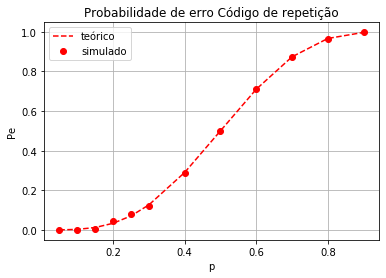

In [9]:
plt.figure()
plt.grid()
plt.plot(p_, Pe_rep, get_color_k(1)+'--')
plt.plot(data_plot[1][0],data_plot[1][1],get_color_k(1)+'o')
plt.title("Probabilidade de erro Código de repetição")
plt.xlabel("p")
plt.ylabel("Pe")
plt.legend(['teórico','simulado'])
plt.show()

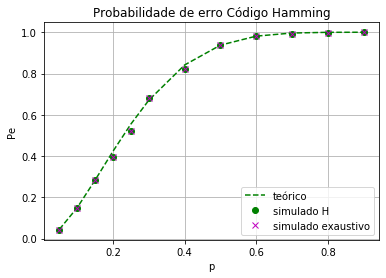

In [10]:
plt.figure()
plt.grid()
plt.plot(p_, Pe_hamming, get_color_k(4)+'--')
plt.plot(data_plot[4][0],data_plot[4][1],get_color_k(4)+'o')
plt.plot(datax_exaustivo, datay_exaustivo,'mx')
plt.title("Probabilidade de erro Código Hamming")
plt.xlabel("p")
plt.ylabel("Pe")
plt.legend(['teórico','simulado H', 'simulado exaustivo'])
plt.show()

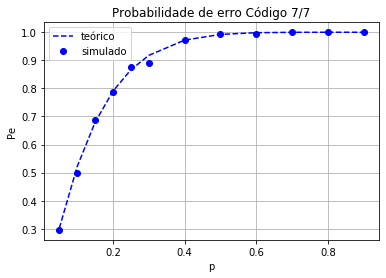

In [11]:
plt.figure()
plt.grid()
plt.plot(p_, Pe_uno, get_color_k(7)+'--')
plt.plot(data_plot[7][0],data_plot[7][1],get_color_k(7)+'o')
plt.title("Probabilidade de erro Código 7/7")
plt.xlabel("p")
plt.ylabel("Pe")
plt.legend(['teórico','simulado'])
plt.show()

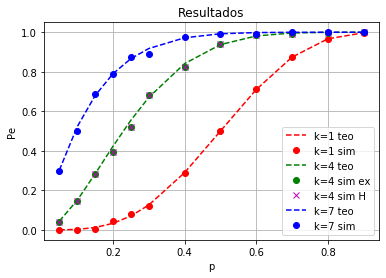

In [12]:
plt.figure()
plt.grid()
plt.plot(p_, Pe_rep, get_color_k(1)+'--')
plt.plot(data_plot[1][0],data_plot[1][1],get_color_k(1)+'o')
plt.plot(p_, Pe_hamming, get_color_k(4)+'--')
plt.plot(data_plot[4][0],data_plot[4][1],get_color_k(4)+'o')
plt.plot(datax_exaustivo, datay_exaustivo,'mx')
plt.plot(p_, Pe_uno, get_color_k(7)+'--')
plt.plot(data_plot[7][0],data_plot[7][1],get_color_k(7)+'o')

plt.title("Resultados")
plt.xlabel("p")
plt.ylabel("Pe")
plt.legend(['k=1 teo', 'k=1 sim', 'k=4 teo', 'k=4 sim ex', 'k=4 sim H', 'k=7 teo', 'k=7 sim'])
plt.show()